<a id="100"></a>
**HOME**

**Main Idea:**

The standard deviation of daily price returns is a statistical measure that quantifies the dispersion or volatility of an asset's daily returns. It shows how much the daily returns of an asset, deviate from the average (mean) daily return over a certain period.

> * **Volatility from High and Low**
> * **Monthly, Daily, Hourly**
> * **Choose the lowest volatility on each timeframe**

**References:**

- [A comparison of bitcoin futures return and return volatility based on news sentiment contemporaneously or lead-lag](https://www.sciencedirect.com/science/article/abs/pii/S1062940824000846)
- [Forecasting cryptocurrency returns with machine learning](https://www.sciencedirect.com/science/article/abs/pii/S0275531923000314)
- [Bitcoin versus S&P 500 Index: Return and Risk Analysis](https://www.mdpi.com/2297-8747/29/3/44)
- [The asymmetric relationships between the Bitcoin futures’ return, volatility, and trading volume](https://www.sciencedirect.com/science/article/abs/pii/S1059056023002216)
- [Which factors drive Bitcoin volatility: Macroeconomic, technical, or both?](https://onlinelibrary.wiley.com/doi/abs/10.1002/for.2930)
- [Return-volatility relationships in cryptocurrency markets: Evidence from asymmetric quantiles and non-linear ARDL approach](https://www.sciencedirect.com/science/article/pii/S1057521923004106)

**Content:**

* [**Volatility Per Month**](#1)
* [**Volatility Per Day**](#2)
* [**Volatility Per Hour**](#3)
* [**Volatility Summary**](#4)

____

<a id="1"></a>
**Volatility Per Month:**

In [1]:
from binance.client import Client  # we have to replace by requests
import pandas as pd
import time

# Initialize the Binance client
api_key = "sytvkKKUmXPabC877r7MFv7rhibYAMoczrMdTse0OSB6dRyImx1G8yEInE889y00"
api_secret = "KYgkq441X5spXpdDoLELwlcoJ3k7uh9LeXGgf7aQvABSMZl42Py3OUIwFCqVgc6L" # LOAD FROM CSV
client = Client(api_key, api_secret)

def fetch_ohlcv_batch(client, symbol, interval, start_time, limit=1000):
    """
    Fetch a batch of OHLCV data from Binance.
    """
    try:
        candles = client.get_klines(
            symbol=symbol,
            interval=interval,
            startTime=start_time,
            limit=limit
        )
        # Transform data into desired format
        ohlcv = [
            [int(c[0]), float(c[1]), float(c[2]), float(c[3]), float(c[4]), float(c[5])]
            for c in candles
        ]
        return ohlcv
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

def fetch_historical_ohlcv(client, symbol, interval, start_time, limit=1000):
    """
    Fetch historical OHLCV data in batches from Binance.
    """
    all_data = []
    while True:
        data = fetch_ohlcv_batch(client, symbol, interval, start_time, limit)
        if data:
            # Append data to all_data
            all_data.extend(data)
            # Update `start_time` to the timestamp of the last fetched data point + 1 millisecond
            start_time = data[-1][0] + 1
            print(f"Fetched {len(data)} data points. Total so far: {len(all_data)}")
        else:
            print("No more data to fetch or an error occurred.")
            break

        # If the batch size is less than the limit, it means we reached the end of available data
        if len(data) < limit:
            print("Reached the end of available data.")
            break

        # To avoid rate limit issues, wait for a short while
        time.sleep(1)

    # Convert data to DataFrame
    df_daily = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df_daily['timestamp'] = pd.to_datetime(df_daily['timestamp'], unit='ms')
    return df_daily

# Usage example
if __name__ == "__main__":
    # Define parameters
    symbol = 'BTCUSDT'        # Symbol to fetch (without '/')
    interval = Client.KLINE_INTERVAL_1DAY  # Timeframe ('1m', '5m', '1h', '1d', etc.)
    start_time = int(pd.Timestamp("2007-01-01").timestamp() * 1000)  # Start date in milliseconds
    limit = 1000              # Max data points per batch

    # Fetch historical data
    df_daily = fetch_historical_ohlcv(client, symbol, interval, start_time, limit)
    print(f"Total fetched data points: {len(df_daily)}")
    print(df_daily.head())

Fetched 1000 data points. Total so far: 1000
Fetched 1000 data points. Total so far: 2000
Fetched 694 data points. Total so far: 2694
Reached the end of available data.
Total fetched data points: 2694
   timestamp     open     high      low    close       volume
0 2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377
1 2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264
2 2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763
3 2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022
4 2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060


/tmp/ipykernel_1116263/222268517.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_years['volatility'] = (df_last_years['high'] - df_last_years['low']) / df_last_years['low'] * 100
/tmp/ipykernel_1116263/222268517.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_years['month_name'] = df_last_years['timestamp'].dt.month_name()


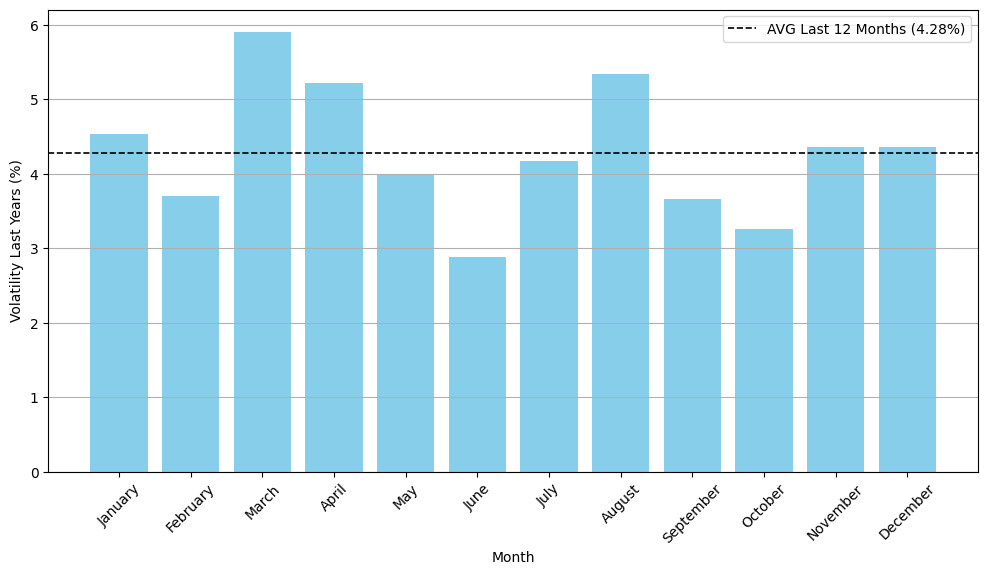

In [2]:
from datetime import timedelta
# Volatility last 12 Months
# Step 1: Filter the last 12 months
twelve_months_ago = df_daily['timestamp'].max() - timedelta(days=365)
df_last_years = df_daily[df_daily['timestamp'] >= twelve_months_ago]

# Step 2: Calculate Hourly Volatility (High-Low Difference Percentage)
df_last_years['volatility'] = (df_last_years['high'] - df_last_years['low']) / df_last_years['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_last_years['month_name'] = df_last_years['timestamp'].dt.month_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
monthly_volatility_last_years = df_last_years.groupby('month_name')['volatility'].mean()

# Sort by calendar order (January to December)
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_volatility_last_years = monthly_volatility_last_years.reindex(month_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(monthly_volatility_last_years.index, monthly_volatility_last_years, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_last_years = monthly_volatility_last_years.mean()
plt.axhline(y=avg_volatility_last_years, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 12 Months ({avg_volatility_last_years:.2f}%)')
plt.ylabel('Volatility Last Years (%)')
plt.xlabel('Month')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [3]:
avg_volatility_last_years

4.277930219118517

/tmp/ipykernel_1116263/2243206011.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_three_years['volatility'] = (df_three_years['high'] - df_three_years['low']) / df_three_years['low'] * 100
/tmp/ipykernel_1116263/2243206011.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_three_years['month_name'] = df_three_years['timestamp'].dt.month_name()


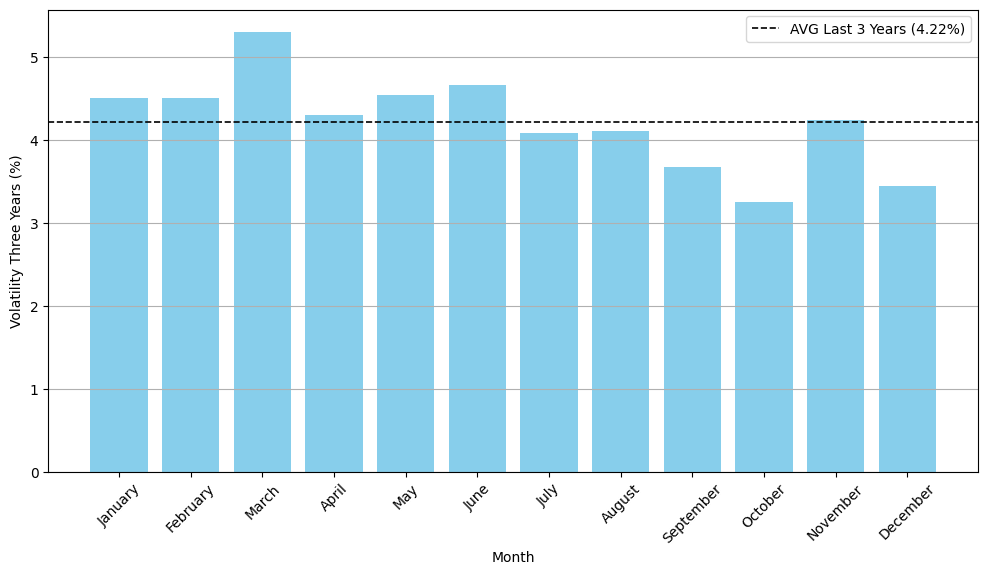

In [4]:
from datetime import timedelta
# Volatility last 36 Months
# Step 1: Filter the last 36 months
threeyears_months_ago = df_daily['timestamp'].max() - timedelta(days=1095)
df_three_years = df_daily[df_daily['timestamp'] >= threeyears_months_ago]

# Step 2: Calculate Hourly Volatility (High-Low Difference Percentage)
df_three_years['volatility'] = (df_three_years['high'] - df_three_years['low']) / df_three_years['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_three_years['month_name'] = df_three_years['timestamp'].dt.month_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
monthly_volatility_three_years = df_three_years.groupby('month_name')['volatility'].mean()

# Sort by calendar order (January to December)
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_volatility_three_years = monthly_volatility_three_years.reindex(month_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(monthly_volatility_three_years.index, monthly_volatility_three_years, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_three_years = monthly_volatility_three_years.mean()
plt.axhline(y=avg_volatility_three_years, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 3 Years ({avg_volatility_three_years:.2f}%)')
plt.ylabel('Volatility Three Years (%)')
plt.xlabel('Month')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [5]:
avg_volatility_three_years

4.2155380115411525

/tmp/ipykernel_1116263/189602728.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_five_years['volatility'] = (df_five_years['high'] - df_five_years['low']) / df_five_years['low'] * 100
/tmp/ipykernel_1116263/189602728.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_five_years['month_name'] = df_five_years['timestamp'].dt.month_name()


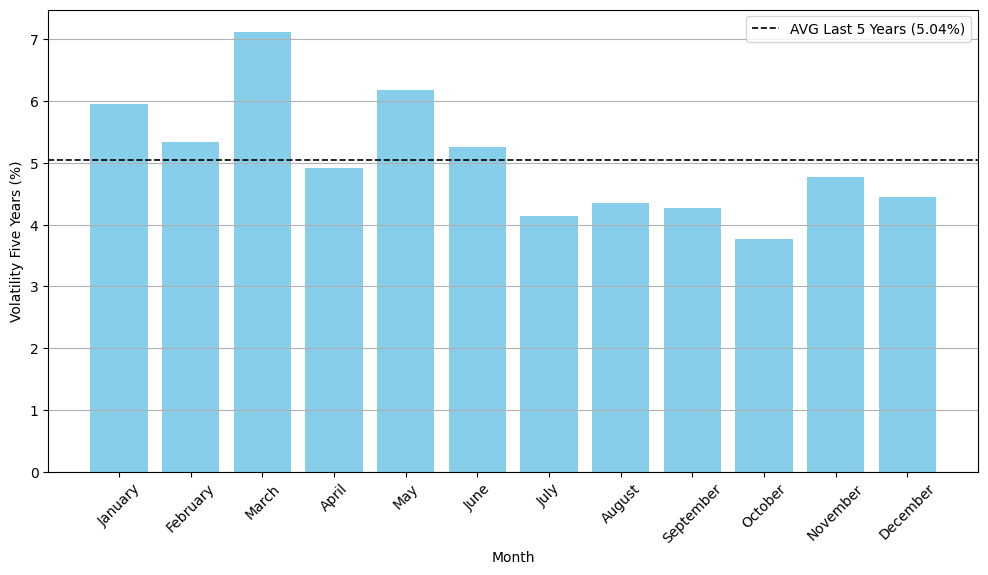

In [6]:
from datetime import timedelta
# Volatility last 60 Months
# Step 1: Filter the last 60 months
fiveyears_months_ago = df_daily['timestamp'].max() - timedelta(days=1825)
df_five_years = df_daily[df_daily['timestamp'] >= fiveyears_months_ago]

# Step 2: Calculate Hourly Volatility (High-Low Difference Percentage)
df_five_years['volatility'] = (df_five_years['high'] - df_five_years['low']) / df_five_years['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_five_years['month_name'] = df_five_years['timestamp'].dt.month_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
monthly_volatility_five_years = df_five_years.groupby('month_name')['volatility'].mean()

# Sort by calendar order (January to December)
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_volatility_five_years = monthly_volatility_five_years.reindex(month_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(monthly_volatility_five_years.index, monthly_volatility_five_years, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_five_years = monthly_volatility_five_years.mean()
plt.axhline(y=avg_volatility_five_years, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 5 Years ({avg_volatility_five_years:.2f}%)')
plt.ylabel('Volatility Five Years (%)')
plt.xlabel('Month')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [7]:
avg_volatility_five_years

5.043027067757377

/tmp/ipykernel_1116263/2062461781.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ten_years['volatility'] = (df_ten_years['high'] - df_ten_years['low']) / df_ten_years['low'] * 100
/tmp/ipykernel_1116263/2062461781.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ten_years['month_name'] = df_ten_years['timestamp'].dt.month_name()


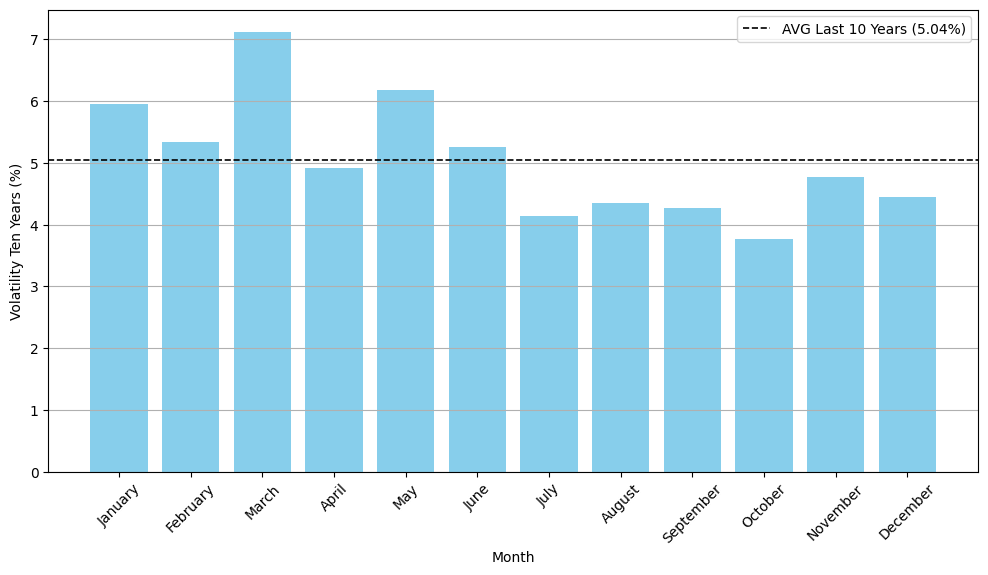

In [8]:
from datetime import timedelta
# Volatility last 60 Months
# Step 1: Filter the last 120 months
tenyears_months_ago = df_daily['timestamp'].max() - timedelta(days=1825)
df_ten_years = df_daily[df_daily['timestamp'] >= tenyears_months_ago]

# Step 2: Calculate Hourly Volatility (High-Low Difference Percentage)
df_ten_years['volatility'] = (df_ten_years['high'] - df_ten_years['low']) / df_ten_years['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_ten_years['month_name'] = df_ten_years['timestamp'].dt.month_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
monthly_volatility_ten_years = df_ten_years.groupby('month_name')['volatility'].mean()

# Sort by calendar order (January to December)
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_volatility_ten_years = monthly_volatility_ten_years.reindex(month_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(monthly_volatility_ten_years.index, monthly_volatility_ten_years, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_ten_years = monthly_volatility_ten_years.mean()
plt.axhline(y=avg_volatility_ten_years, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 10 Years ({avg_volatility_ten_years:.2f}%)')
plt.ylabel('Volatility Ten Years (%)')
plt.xlabel('Month')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [9]:
avg_volatility_ten_years

5.043027067757377

Summary Volatility Per Month:

In [10]:
print(avg_volatility_last_years)
print(avg_volatility_three_years)
print(avg_volatility_five_years)
print(avg_volatility_ten_years)

4.277930219118517
4.2155380115411525
5.043027067757377
5.043027067757377


/tmp/ipykernel_1116263/222268517.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_years['volatility'] = (df_last_years['high'] - df_last_years['low']) / df_last_years['low'] * 100
/tmp/ipykernel_1116263/222268517.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_years['month_name'] = df_last_years['timestamp'].dt.month_name()


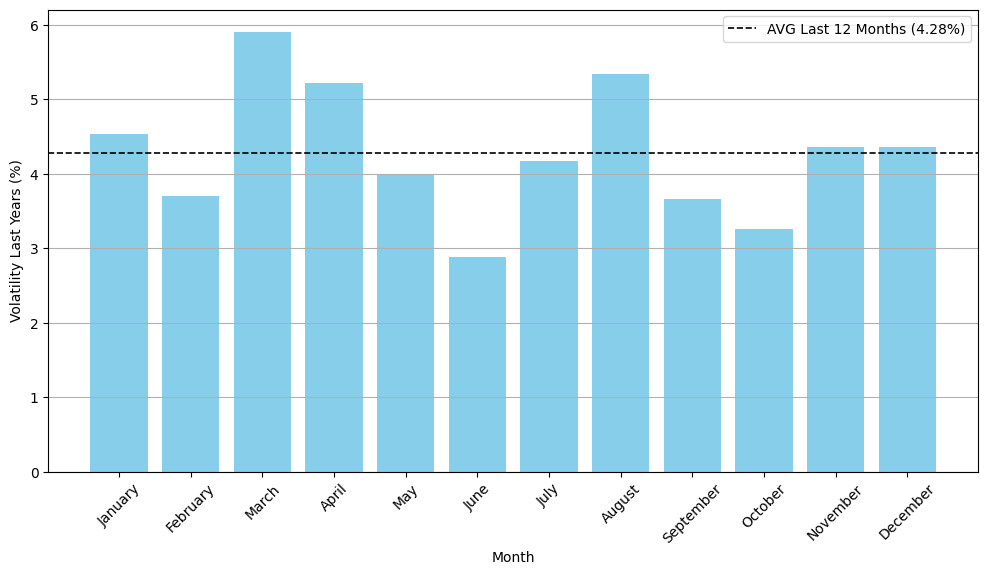

In [11]:
from datetime import timedelta
# Volatility last 12 Months
# Step 1: Filter the last 12 months
twelve_months_ago = df_daily['timestamp'].max() - timedelta(days=365)
df_last_years = df_daily[df_daily['timestamp'] >= twelve_months_ago]

# Step 2: Calculate Hourly Volatility (High-Low Difference Percentage)
df_last_years['volatility'] = (df_last_years['high'] - df_last_years['low']) / df_last_years['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_last_years['month_name'] = df_last_years['timestamp'].dt.month_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
monthly_volatility_last_years = df_last_years.groupby('month_name')['volatility'].mean()

# Sort by calendar order (January to December)
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_volatility_last_years = monthly_volatility_last_years.reindex(month_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(monthly_volatility_last_years.index, monthly_volatility_last_years, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_last_years = monthly_volatility_last_years.mean()
plt.axhline(y=avg_volatility_last_years, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 12 Months ({avg_volatility_last_years:.2f}%)')
plt.ylabel('Volatility Last Years (%)')
plt.xlabel('Month')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

<a name="id"></a>
[**Back to HOME**](#100)

<a id="2"></a>
**Volatility Per Day:**

In [12]:
from binance.client import Client
import pandas as pd
import time

# Initialize the Binance client
api_key = "sytvkKKUmXPabC877r7MFv7rhibYAMoczrMdTse0OSB6dRyImx1G8yEInE889y00"
api_secret = "KYgkq441X5spXpdDoLELwlcoJ3k7uh9LeXGgf7aQvABSMZl42Py3OUIwFCqVgc6L"
client = Client(api_key, api_secret)

def fetch_ohlcv_batch(client, symbol, interval, start_time, limit=1000):
    """
    Fetch a batch of OHLCV data from Binance.
    """
    try:
        candles = client.get_klines(
            symbol=symbol,
            interval=interval,
            startTime=start_time,
            limit=limit
        )
        # Transform data into desired format
        ohlcv = [
            [int(c[0]), float(c[1]), float(c[2]), float(c[3]), float(c[4]), float(c[5])]
            for c in candles
        ]
        return ohlcv
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

def fetch_historical_ohlcv(client, symbol, interval, start_time, limit=1000):
    """
    Fetch historical OHLCV data in batches from Binance.
    """
    all_data = []
    while True:
        data = fetch_ohlcv_batch(client, symbol, interval, start_time, limit)
        if data:
            # Append data to all_data
            all_data.extend(data)
            # Update `start_time` to the timestamp of the last fetched data point + 1 millisecond
            start_time = data[-1][0] + 1
            print(f"Fetched {len(data)} data points. Total so far: {len(all_data)}")
        else:
            print("No more data to fetch or an error occurred.")
            break

        # If the batch size is less than the limit, it means we reached the end of available data
        if len(data) < limit:
            print("Reached the end of available data.")
            break

        # To avoid rate limit issues, wait for a short while
        time.sleep(1)

    # Convert data to DataFrame
    df_daily = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df_daily['timestamp'] = pd.to_datetime(df_daily['timestamp'], unit='ms')
    return df_daily

# Usage example
if __name__ == "__main__":
    # Define parameters
    symbol = 'BTCUSDT'        # Symbol to fetch (without '/')
    interval = Client.KLINE_INTERVAL_1DAY  # Timeframe ('1m', '5m', '1h', '1d', etc.)
    start_time = int(pd.Timestamp("2007-01-01").timestamp() * 1000)  # Start date in milliseconds
    limit = 1000              # Max data points per batch

    # Fetch historical data
    df_daily = fetch_historical_ohlcv(client, symbol, interval, start_time, limit)
    print(f"Total fetched data points: {len(df_daily)}")
    print(df_daily.head())

Fetched 1000 data points. Total so far: 1000
Fetched 1000 data points. Total so far: 2000
Fetched 694 data points. Total so far: 2694
Reached the end of available data.
Total fetched data points: 2694
   timestamp     open     high      low    close       volume
0 2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377
1 2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264
2 2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763
3 2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022
4 2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060


/tmp/ipykernel_1116263/1802304221.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_sevendays['volatility'] = (df_last_sevendays['high'] - df_last_sevendays['low']) / df_last_sevendays['low'] * 100
/tmp/ipykernel_1116263/1802304221.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_sevendays['day_name'] = df_last_sevendays['timestamp'].dt.day_name()


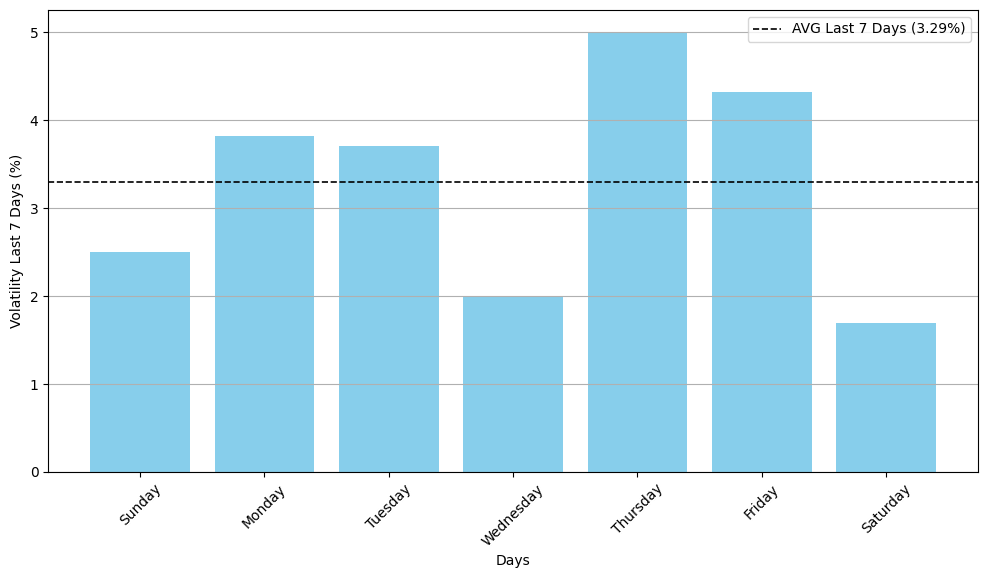

In [13]:
from datetime import timedelta
# Volatility last 7 days
# Step 1: Filter the last 7 days
seven_days_ago = df_daily['timestamp'].max() - timedelta(days=7)
df_last_sevendays = df_daily[df_daily['timestamp'] >= seven_days_ago]

# Step 2: Calculate Daily Volatility (High-Low Difference Percentage)
df_last_sevendays['volatility'] = (df_last_sevendays['high'] - df_last_sevendays['low']) / df_last_sevendays['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_last_sevendays['day_name'] = df_last_sevendays['timestamp'].dt.day_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
daily_volatility_last_sevendays = df_last_sevendays.groupby('day_name')['volatility'].mean()

# Sort by calendar order (January to December)
day_order = [
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
    'Saturday'
]
daily_volatility_last_sevendays = daily_volatility_last_sevendays.reindex(day_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(daily_volatility_last_sevendays.index, daily_volatility_last_sevendays, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_last_sevendays = daily_volatility_last_sevendays.mean()
plt.axhline(y=avg_volatility_last_sevendays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 7 Days ({avg_volatility_last_sevendays:.2f}%)')
plt.ylabel('Volatility Last 7 Days (%)')
plt.xlabel('Days')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [14]:
avg_volatility_last_sevendays

3.292174446845011

/tmp/ipykernel_1116263/1701650920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_thirtydays['volatility'] = (df_last_thirtydays['high'] - df_last_thirtydays['low']) / df_last_thirtydays['low'] * 100
/tmp/ipykernel_1116263/1701650920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_thirtydays['day_name'] = df_last_thirtydays['timestamp'].dt.day_name()


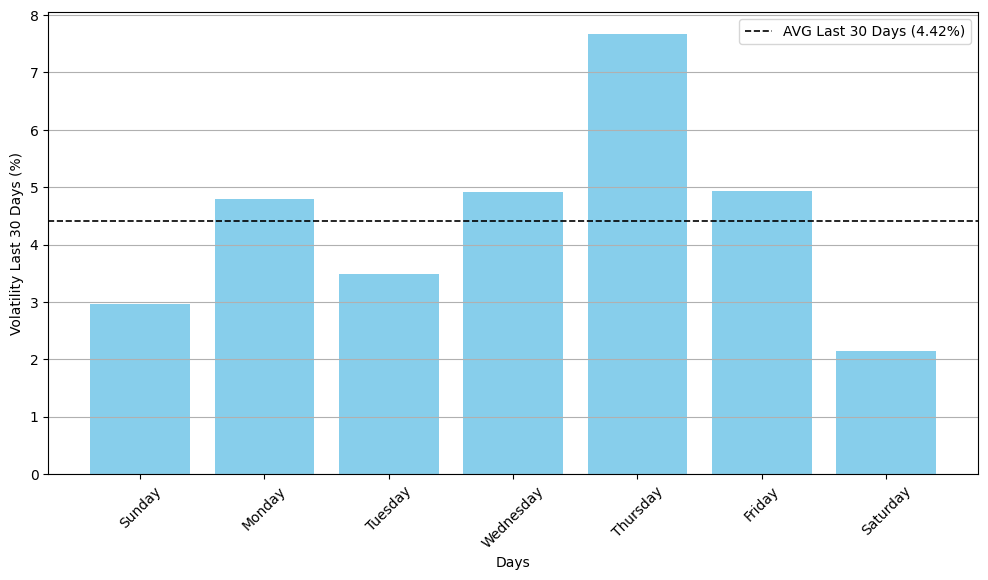

In [15]:
from datetime import timedelta
# Volatility last 30 days
# Step 1: Filter the last 30 days
thirty_days_ago = df_daily['timestamp'].max() - timedelta(days=30)
df_last_thirtydays = df_daily[df_daily['timestamp'] >= thirty_days_ago]

# Step 2: Calculate Daily Volatility (High-Low Difference Percentage)
df_last_thirtydays['volatility'] = (df_last_thirtydays['high'] - df_last_thirtydays['low']) / df_last_thirtydays['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_last_thirtydays['day_name'] = df_last_thirtydays['timestamp'].dt.day_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
daily_volatility_last_thirtydays = df_last_thirtydays.groupby('day_name')['volatility'].mean()

# Sort by calendar order (January to December)
day_order = [
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
    'Saturday'
]
daily_volatility_last_thirtydays = daily_volatility_last_thirtydays.reindex(day_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(daily_volatility_last_thirtydays.index, daily_volatility_last_thirtydays, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_last_thirtydays = daily_volatility_last_thirtydays.mean()
plt.axhline(y=avg_volatility_last_thirtydays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 30 Days ({avg_volatility_last_thirtydays:.2f}%)')
plt.ylabel('Volatility Last 30 Days (%)')
plt.xlabel('Days')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [16]:
avg_volatility_last_thirtydays

4.41697182567911

/tmp/ipykernel_1116263/425896180.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_ninetydays['volatility'] = (df_last_ninetydays['high'] - df_last_ninetydays['low']) / df_last_ninetydays['low'] * 100
/tmp/ipykernel_1116263/425896180.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_ninetydays['day_name'] = df_last_ninetydays['timestamp'].dt.day_name()


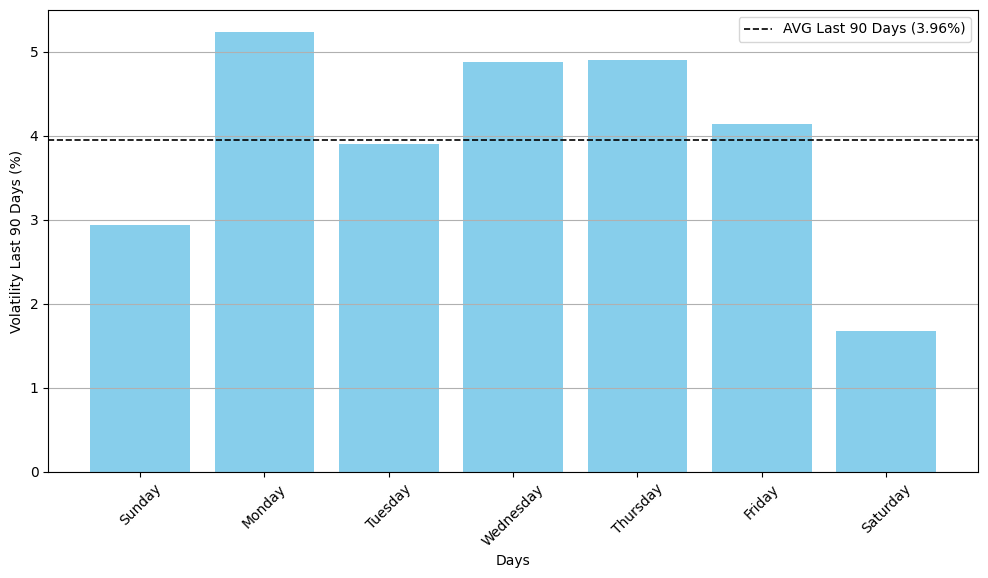

In [17]:
from datetime import timedelta
# Volatility last 90 days
# Step 1: Filter the last 90 days
ninety_days_ago = df_daily['timestamp'].max() - timedelta(days=90)
df_last_ninetydays = df_daily[df_daily['timestamp'] >= ninety_days_ago]

# Step 2: Calculate Daily Volatility (High-Low Difference Percentage)
df_last_ninetydays['volatility'] = (df_last_ninetydays['high'] - df_last_ninetydays['low']) / df_last_ninetydays['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_last_ninetydays['day_name'] = df_last_ninetydays['timestamp'].dt.day_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
daily_volatility_last_ninetydays = df_last_ninetydays.groupby('day_name')['volatility'].mean()

# Sort by calendar order (January to December)
day_order = [
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
    'Saturday'
]
daily_volatility_last_ninetydays = daily_volatility_last_ninetydays.reindex(day_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(daily_volatility_last_ninetydays.index, daily_volatility_last_ninetydays, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_last_ninetydays = daily_volatility_last_ninetydays.mean()
plt.axhline(y=avg_volatility_last_ninetydays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 90 Days ({avg_volatility_last_ninetydays:.2f}%)')
plt.ylabel('Volatility Last 90 Days (%)')
plt.xlabel('Days')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [18]:
avg_volatility_last_ninetydays

3.955606720038605

/tmp/ipykernel_1116263/4063245001.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_onehundredeightydays['volatility'] = (df_last_onehundredeightydays['high'] - df_last_onehundredeightydays['low']) / df_last_onehundredeightydays['low'] * 100
/tmp/ipykernel_1116263/4063245001.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_onehundredeightydays['day_name'] = df_last_onehundredeightydays['timestamp'].dt.day_name()


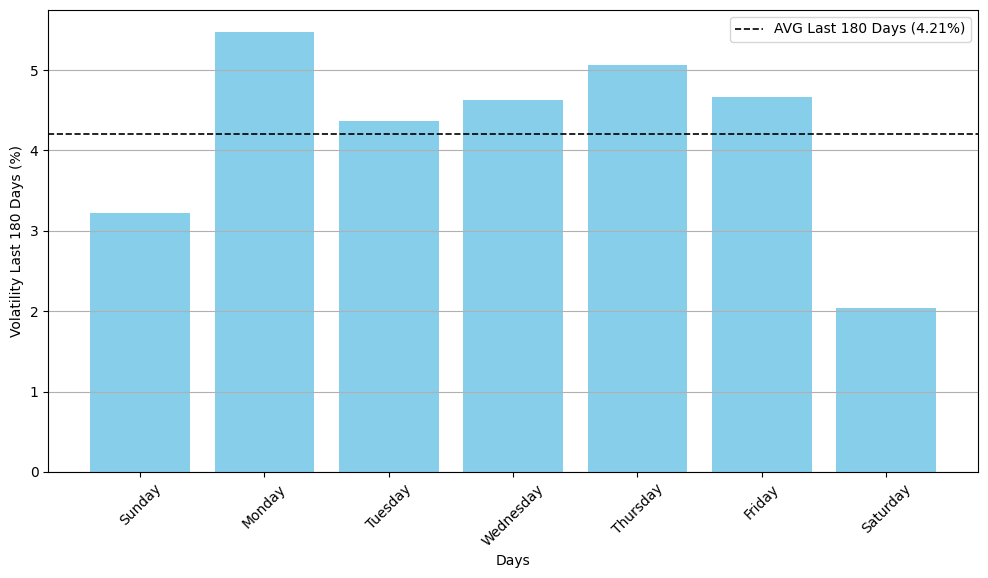

In [19]:
from datetime import timedelta
# Volatility last 180 days
# Step 1: Filter the last 180 days
onehundredeighty_days_ago = df_daily['timestamp'].max() - timedelta(days=180)
df_last_onehundredeightydays = df_daily[df_daily['timestamp'] >= onehundredeighty_days_ago]

# Step 2: Calculate Daily Volatility (High-Low Difference Percentage)
df_last_onehundredeightydays['volatility'] = (df_last_onehundredeightydays['high'] - df_last_onehundredeightydays['low']) / df_last_onehundredeightydays['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_last_onehundredeightydays['day_name'] = df_last_onehundredeightydays['timestamp'].dt.day_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
daily_volatility_last_onehundredeightydays = df_last_onehundredeightydays.groupby('day_name')['volatility'].mean()

# Sort by calendar order (January to December)
day_order = [
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
    'Saturday'
]
daily_volatility_last_onehundredeightydays = daily_volatility_last_onehundredeightydays.reindex(day_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(daily_volatility_last_onehundredeightydays.index, daily_volatility_last_onehundredeightydays, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_last_onehundredeightydays = daily_volatility_last_onehundredeightydays.mean()
plt.axhline(y=avg_volatility_last_onehundredeightydays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 180 Days ({avg_volatility_last_onehundredeightydays:.2f}%)')
plt.ylabel('Volatility Last 180 Days (%)')
plt.xlabel('Days')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [20]:
avg_volatility_last_onehundredeightydays

4.20933876407938

/tmp/ipykernel_1116263/2463295098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_threehundredsixtydays['volatility'] = (df_last_threehundredsixtydays['high'] - df_last_threehundredsixtydays['low']) / df_last_threehundredsixtydays['low'] * 100
/tmp/ipykernel_1116263/2463295098.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_threehundredsixtydays['day_name'] = df_last_threehundredsixtydays['timestamp'].dt.day_name()


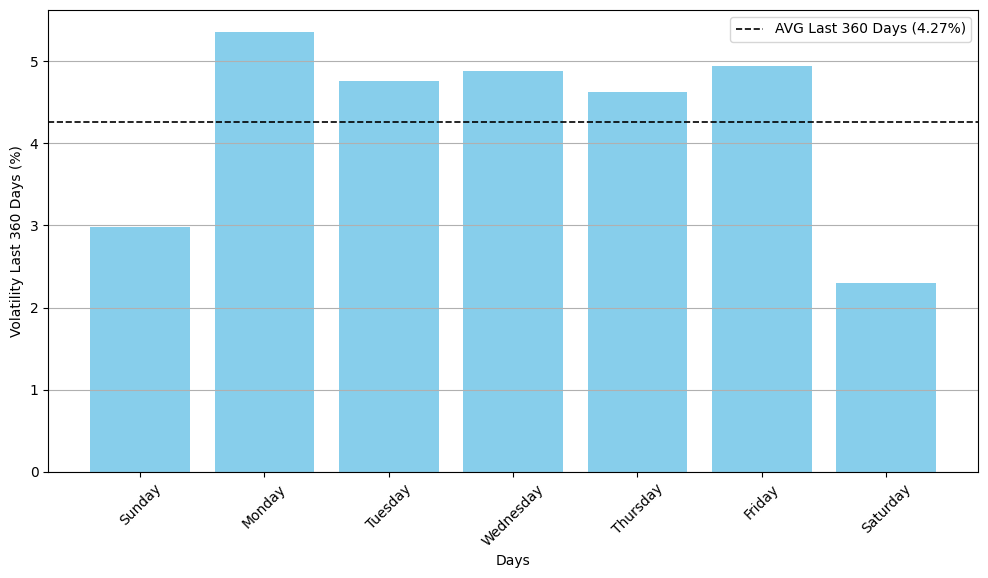

In [21]:
from datetime import timedelta
# Volatility last 360 days
# Step 1: Filter the last 360 days
threehundredsixty_days_ago = df_daily['timestamp'].max() - timedelta(days=360)
df_last_threehundredsixtydays = df_daily[df_daily['timestamp'] >= threehundredsixty_days_ago]

# Step 2: Calculate Daily Volatility (High-Low Difference Percentage)
df_last_threehundredsixtydays['volatility'] = (df_last_threehundredsixtydays['high'] - df_last_threehundredsixtydays['low']) / df_last_threehundredsixtydays['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_last_threehundredsixtydays['day_name'] = df_last_threehundredsixtydays['timestamp'].dt.day_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
daily_volatility_last_threehundredsixtydays = df_last_threehundredsixtydays.groupby('day_name')['volatility'].mean()

# Sort by calendar order (January to December)
day_order = [
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
    'Saturday'
]
daily_volatility_last_threehundredsixtydays = daily_volatility_last_threehundredsixtydays.reindex(day_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(daily_volatility_last_threehundredsixtydays.index, daily_volatility_last_threehundredsixtydays, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_last_threehundredsixtydays = daily_volatility_last_threehundredsixtydays.mean()
plt.axhline(y=avg_volatility_last_threehundredsixtydays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 360 Days ({avg_volatility_last_threehundredsixtydays:.2f}%)')
plt.ylabel('Volatility Last 360 Days (%)')
plt.xlabel('Days')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [22]:
avg_volatility_last_threehundredsixtydays

4.26533140763655

Summary:

In [23]:
print(avg_volatility_last_sevendays)
print(avg_volatility_last_thirtydays)
print(avg_volatility_last_ninetydays)
print(avg_volatility_last_onehundredeightydays)
print(avg_volatility_last_threehundredsixtydays)

3.292174446845011
4.41697182567911
3.955606720038605
4.20933876407938
4.26533140763655


/tmp/ipykernel_1116263/425896180.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_ninetydays['volatility'] = (df_last_ninetydays['high'] - df_last_ninetydays['low']) / df_last_ninetydays['low'] * 100
/tmp/ipykernel_1116263/425896180.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_ninetydays['day_name'] = df_last_ninetydays['timestamp'].dt.day_name()


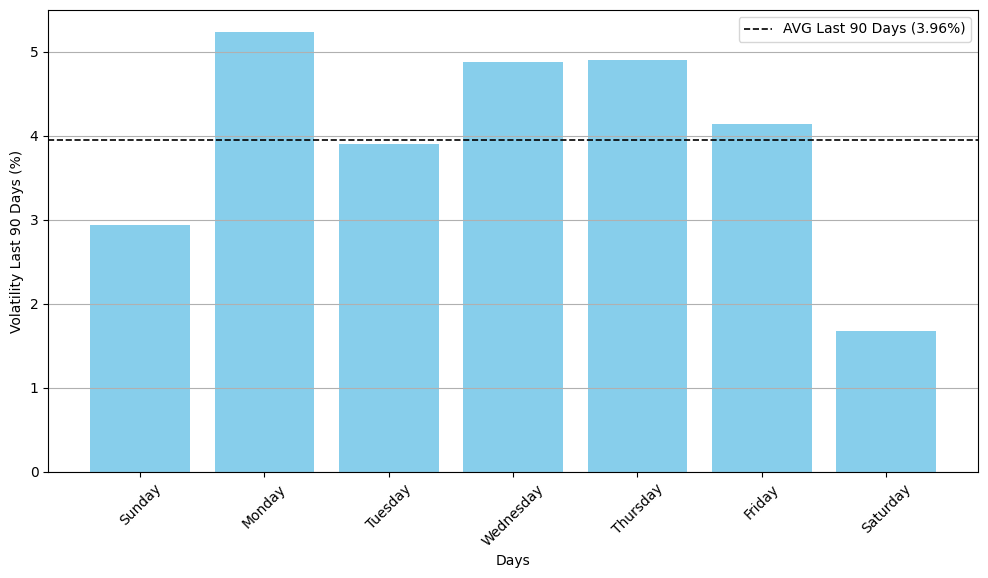

In [24]:
from datetime import timedelta
# Volatility last 90 days
# Step 1: Filter the last 90 days
ninety_days_ago = df_daily['timestamp'].max() - timedelta(days=90)
df_last_ninetydays = df_daily[df_daily['timestamp'] >= ninety_days_ago]

# Step 2: Calculate Daily Volatility (High-Low Difference Percentage)
df_last_ninetydays['volatility'] = (df_last_ninetydays['high'] - df_last_ninetydays['low']) / df_last_ninetydays['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_last_ninetydays['day_name'] = df_last_ninetydays['timestamp'].dt.day_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
daily_volatility_last_ninetydays = df_last_ninetydays.groupby('day_name')['volatility'].mean()

# Sort by calendar order (January to December)
day_order = [
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
    'Saturday'
]
daily_volatility_last_ninetydays = daily_volatility_last_ninetydays.reindex(day_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(daily_volatility_last_ninetydays.index, daily_volatility_last_ninetydays, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_last_ninetydays = daily_volatility_last_ninetydays.mean()
plt.axhline(y=avg_volatility_last_ninetydays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 90 Days ({avg_volatility_last_ninetydays:.2f}%)')
plt.ylabel('Volatility Last 90 Days (%)')
plt.xlabel('Days')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

<a name="id"></a>
[**Back to HOME**](#100)

<a id="3"></a>
**Volatility Per Hour:**

In [25]:
from binance.client import Client
import pandas as pd
import time

# Initialize the Binance client
api_key = "sytvkKKUmXPabC877r7MFv7rhibYAMoczrMdTse0OSB6dRyImx1G8yEInE889y00"
api_secret = "KYgkq441X5spXpdDoLELwlcoJ3k7uh9LeXGgf7aQvABSMZl42Py3OUIwFCqVgc6L"
client = Client(api_key, api_secret)

def fetch_ohlcv_batch(client, symbol, interval, start_time, limit=1000):
    """
    Fetch a batch of OHLCV data from Binance.
    """
    try:
        candles = client.get_klines(
            symbol=symbol,
            interval=interval,
            startTime=start_time,
            limit=limit
        )
        # Transform data into desired format
        ohlcv = [
            [int(c[0]), float(c[1]), float(c[2]), float(c[3]), float(c[4]), float(c[5])]
            for c in candles
        ]
        return ohlcv
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

def fetch_historical_ohlcv(client, symbol, interval, start_time, limit=1000):
    """
    Fetch historical OHLCV data in batches from Binance.
    """
    all_data = []
    while True:
        data = fetch_ohlcv_batch(client, symbol, interval, start_time, limit)
        if data:
            # Append data to all_data
            all_data.extend(data)
            # Update `start_time` to the timestamp of the last fetched data point + 1 millisecond
            start_time = data[-1][0] + 1
            print(f"Fetched {len(data)} data points. Total so far: {len(all_data)}")
        else:
            print("No more data to fetch or an error occurred.")
            break

        # If the batch size is less than the limit, it means we reached the end of available data
        if len(data) < limit:
            print("Reached the end of available data.")
            break

        # To avoid rate limit issues, wait for a short while
        time.sleep(1)

    # Convert data to DataFrame
    df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# Usage example
if __name__ == "__main__":
    # Define parameters
    symbol = 'BTCUSDT'        # Symbol to fetch (without '/')
    interval = Client.KLINE_INTERVAL_1HOUR  # Changed to hourly ('1h')
    start_time = int(pd.Timestamp("2020-01-01").timestamp() * 1000)  # Start date in milliseconds
    limit = 1000              # Max data points per batch

    # Fetch historical data
    df_hourly = fetch_historical_ohlcv(client, symbol, interval, start_time, limit)
    print(f"Total fetched data points: {len(df_hourly)}")
    print(df_hourly.head())

Fetched 1000 data points. Total so far: 1000
Fetched 1000 data points. Total so far: 2000
Fetched 1000 data points. Total so far: 3000
Fetched 1000 data points. Total so far: 4000
Fetched 1000 data points. Total so far: 5000
Fetched 1000 data points. Total so far: 6000
Fetched 1000 data points. Total so far: 7000
Fetched 1000 data points. Total so far: 8000
Fetched 1000 data points. Total so far: 9000
Fetched 1000 data points. Total so far: 10000
Fetched 1000 data points. Total so far: 11000
Fetched 1000 data points. Total so far: 12000
Fetched 1000 data points. Total so far: 13000
Fetched 1000 data points. Total so far: 14000
Fetched 1000 data points. Total so far: 15000
Fetched 1000 data points. Total so far: 16000
Fetched 1000 data points. Total so far: 17000
Fetched 1000 data points. Total so far: 18000
Fetched 1000 data points. Total so far: 19000
Fetched 1000 data points. Total so far: 20000
Fetched 1000 data points. Total so far: 21000
Fetched 1000 data points. Total so far: 220

/tmp/ipykernel_1116263/1409784927.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_7_days['hour'] = df_last_7_days['timestamp'].dt.hour
/tmp/ipykernel_1116263/1409784927.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_7_days['volatility'] = (df_last_7_days['high'] - df_last_7_days['low']) / df_last_7_days['low'] * 100


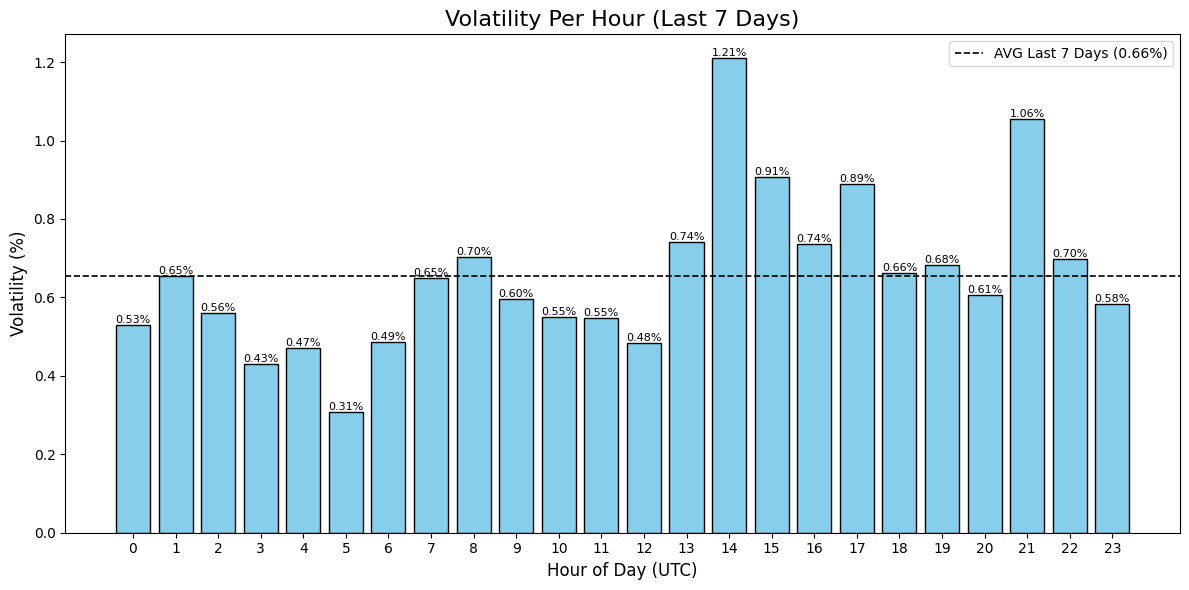

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
# Last 7 days
# Example: Assuming your data is loaded into a DataFrame 'df'
# and contains 'datetime', 'high', and 'low' columns
# df = pd.read_csv('your_bitcoin_data.csv')  # Replace with your actual data file

# Convert datetime to a pandas datetime object
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])

# Filter data for the last 7 days
last_7_days = datetime.now() - timedelta(days=7)
df_last_7_days = df_hourly[df_hourly['timestamp'] >= last_7_days]

# Extract hour from datetime
df_last_7_days['hour'] = df_last_7_days['timestamp'].dt.hour

# Calculate Hourly Volatility (High-Low Difference Percentage)
df_last_7_days['volatility'] = (df_last_7_days['high'] - df_last_7_days['low']) / df_last_7_days['low'] * 100

# Group by Hour and Calculate Average Volatility
hourly_volatility = df_last_7_days.groupby('hour')['volatility'].mean()

# Prepare the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(hourly_volatility.index, hourly_volatility, color='skyblue', edgecolor='black')

# Highlight the Average Line
average_hr_volatility_last_sevendays = hourly_volatility.mean()
plt.axhline(y=average_hr_volatility_last_sevendays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 7 Days ({average_hr_volatility_last_sevendays:.2f}%)')

# Annotate Bars with Values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

# Add Chart Labels and Title
plt.title('Volatility Per Hour (Last 7 Days)', fontsize=16)
plt.xlabel('Hour of Day (UTC)', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.legend()

# Show the Plot
plt.tight_layout()
plt.show()

In [27]:
average_hr_volatility_last_sevendays

0.6558569197198737

/tmp/ipykernel_1116263/2165635429.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_30_days['hour'] = df_last_30_days['timestamp'].dt.hour
/tmp/ipykernel_1116263/2165635429.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_30_days['volatility'] = (df_last_30_days['high'] - df_last_30_days['low']) / df_last_30_days['low'] * 100


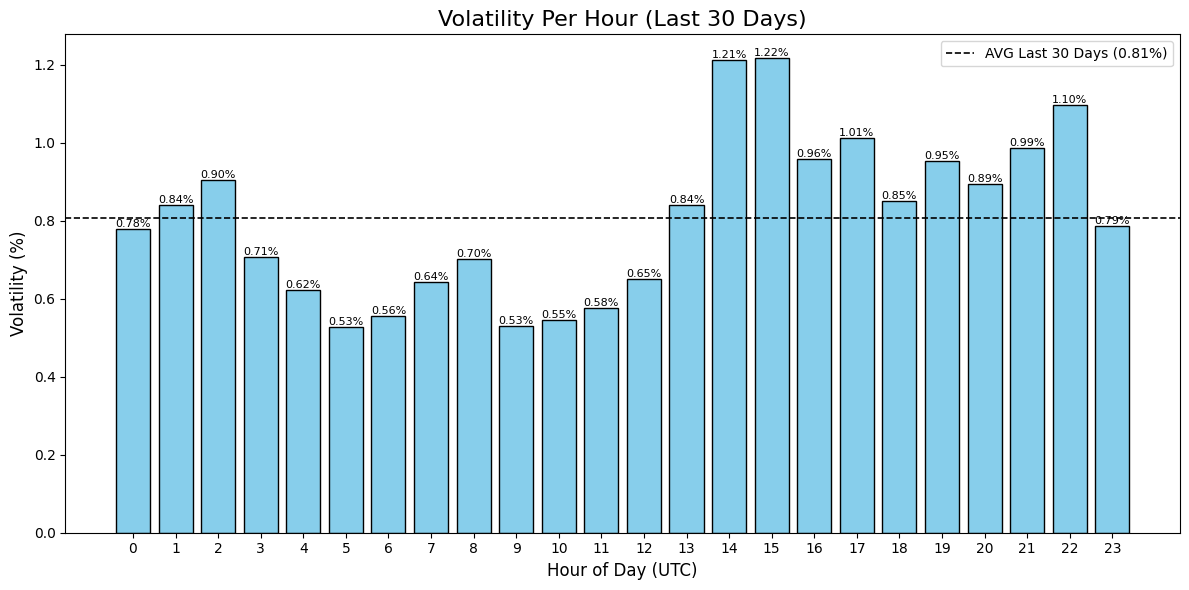

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
# Last 30 days
# Example: Assuming your data is loaded into a DataFrame 'df'
# and contains 'datetime', 'high', and 'low' columns
# df = pd.read_csv('your_bitcoin_data.csv')  # Replace with your actual data file

# Convert datetime to a pandas datetime object
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])

# Filter data for the last 30 days
last_30_days = datetime.now() - timedelta(days=30)
df_last_30_days = df_hourly[df_hourly['timestamp'] >= last_30_days]

# Extract hour from datetime
df_last_30_days['hour'] = df_last_30_days['timestamp'].dt.hour

# Calculate Hourly Volatility (High-Low Difference Percentage)
df_last_30_days['volatility'] = (df_last_30_days['high'] - df_last_30_days['low']) / df_last_30_days['low'] * 100

# Group by Hour and Calculate Average Volatility
hourly_volatility = df_last_30_days.groupby('hour')['volatility'].mean()

# Prepare the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(hourly_volatility.index, hourly_volatility, color='skyblue', edgecolor='black')

# Highlight the Average Line
average_hr_volatility_last_thirtydays = hourly_volatility.mean()
plt.axhline(y=average_hr_volatility_last_thirtydays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 30 Days ({average_hr_volatility_last_thirtydays:.2f}%)')

# Annotate Bars with Values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

# Add Chart Labels and Title
plt.title('Volatility Per Hour (Last 30 Days)', fontsize=16)
plt.xlabel('Hour of Day (UTC)', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.legend()

# Show the Plot
plt.tight_layout()
plt.show()

In [29]:
average_hr_volatility_last_thirtydays

0.80742375956675

/tmp/ipykernel_1116263/3335403656.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_3_months['hour'] = df_last_3_months['timestamp'].dt.hour
/tmp/ipykernel_1116263/3335403656.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_3_months['volatility'] = (df_last_3_months['high'] - df_last_3_months['low']) / df_last_3_months['low'] * 100


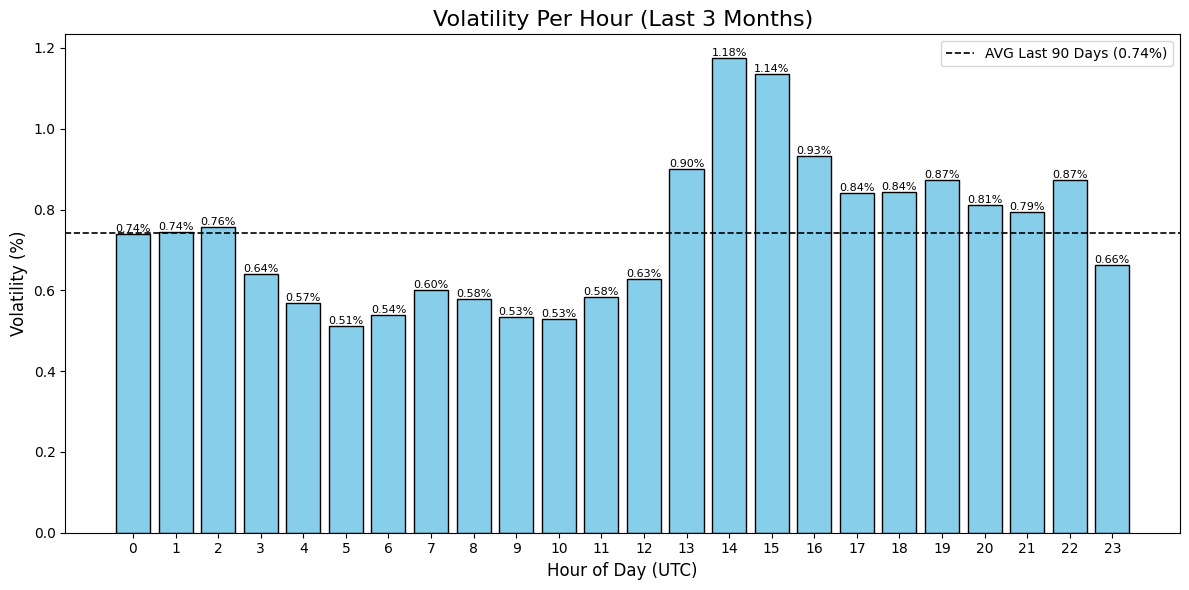

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
# Last 3 Month

# Convert datetime to a pandas datetime object
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])

# Filter data for the last 3 months (90 days)
last_3_months = datetime.now() - timedelta(days=90)
df_last_3_months = df_hourly[df_hourly['timestamp'] >= last_3_months]

# Extract hour from datetime
df_last_3_months['hour'] = df_last_3_months['timestamp'].dt.hour

# Calculate Hourly Volatility (High-Low Difference Percentage)
df_last_3_months['volatility'] = (df_last_3_months['high'] - df_last_3_months['low']) / df_last_3_months['low'] * 100

# Group by Hour and Calculate Average Volatility
hourly_volatility = df_last_3_months.groupby('hour')['volatility'].mean()

# Prepare the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(hourly_volatility.index, hourly_volatility, color='skyblue', edgecolor='black')

# Highlight the Average Line
average_hr_volatility_last_ninetydays = hourly_volatility.mean()
plt.axhline(y=average_hr_volatility_last_ninetydays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 90 Days ({average_hr_volatility_last_ninetydays:.2f}%)')

# Annotate Bars with Values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

# Add Chart Labels and Title
plt.title('Volatility Per Hour (Last 3 Months)', fontsize=16)
plt.xlabel('Hour of Day (UTC)', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.legend()

# Show the Plot
plt.tight_layout()
plt.show()

In [31]:
average_hr_volatility_last_ninetydays

0.7416390866060801

/tmp/ipykernel_1116263/836438165.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['hour'] = df_last_6_months['timestamp'].dt.hour
/tmp/ipykernel_1116263/836438165.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['volatility'] = (df_last_6_months['high'] - df_last_6_months['low']) / df_last_6_months['low'] * 100


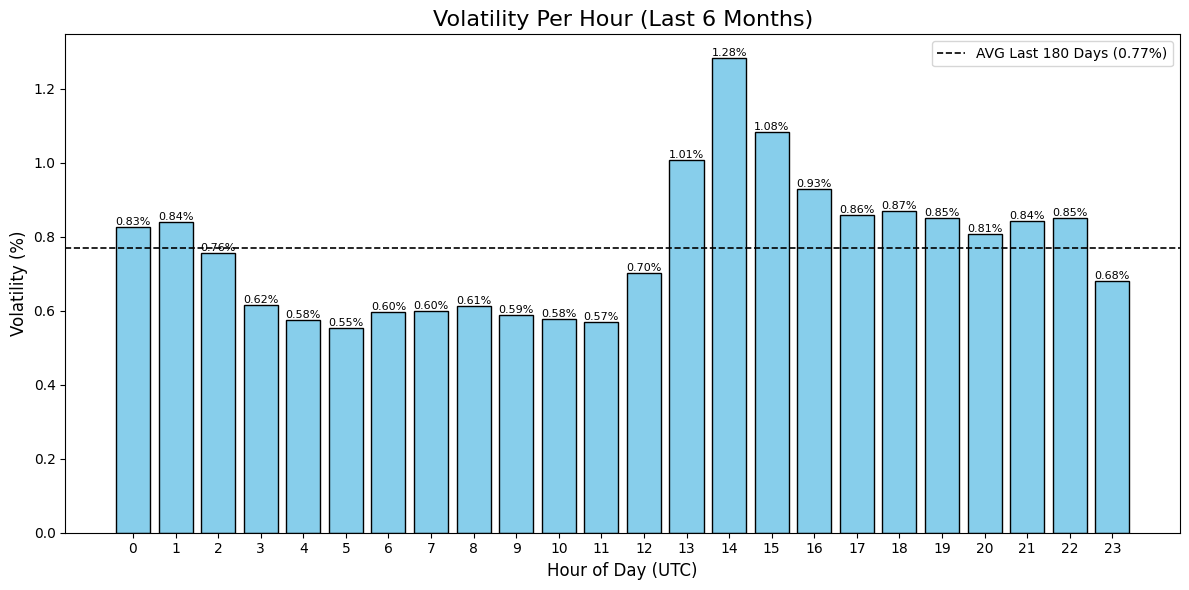

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
# Last 180 Days
# Example: Assuming your data is loaded into a DataFrame 'df'
# and contains 'datetime', 'high', and 'low' columns
# df = pd.read_csv('your_bitcoin_data.csv')  # Replace with your actual data file

# Convert datetime to a pandas datetime object
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])

# Filter data for the last 6 months (180 days)
last_6_months = datetime.now() - timedelta(days=180)
df_last_6_months = df_hourly[df_hourly['timestamp'] >= last_6_months]

# Extract hour from datetime
df_last_6_months['hour'] = df_last_6_months['timestamp'].dt.hour

# Calculate Hourly Volatility (High-Low Difference Percentage)
df_last_6_months['volatility'] = (df_last_6_months['high'] - df_last_6_months['low']) / df_last_6_months['low'] * 100

# Group by Hour and Calculate Average Volatility
hourly_volatility = df_last_6_months.groupby('hour')['volatility'].mean()

# Prepare the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(hourly_volatility.index, hourly_volatility, color='skyblue', edgecolor='black')

# Highlight the Average Line
average_hr_volatility_last_onehundredeighty = hourly_volatility.mean()
plt.axhline(y=average_hr_volatility_last_onehundredeighty, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 180 Days ({average_hr_volatility_last_onehundredeighty:.2f}%)')

# Annotate Bars with Values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

# Add Chart Labels and Title
plt.title('Volatility Per Hour (Last 6 Months)', fontsize=16)
plt.xlabel('Hour of Day (UTC)', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.legend()

# Show the Plot
plt.tight_layout()
plt.show()

In [33]:
average_hr_volatility_last_onehundredeighty

0.7703249408933658

/tmp/ipykernel_1116263/48182996.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_12_months['hour'] = df_last_12_months['timestamp'].dt.hour
/tmp/ipykernel_1116263/48182996.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_12_months['volatility'] = (df_last_12_months['high'] - df_last_12_months['low']) / df_last_12_months['low'] * 100


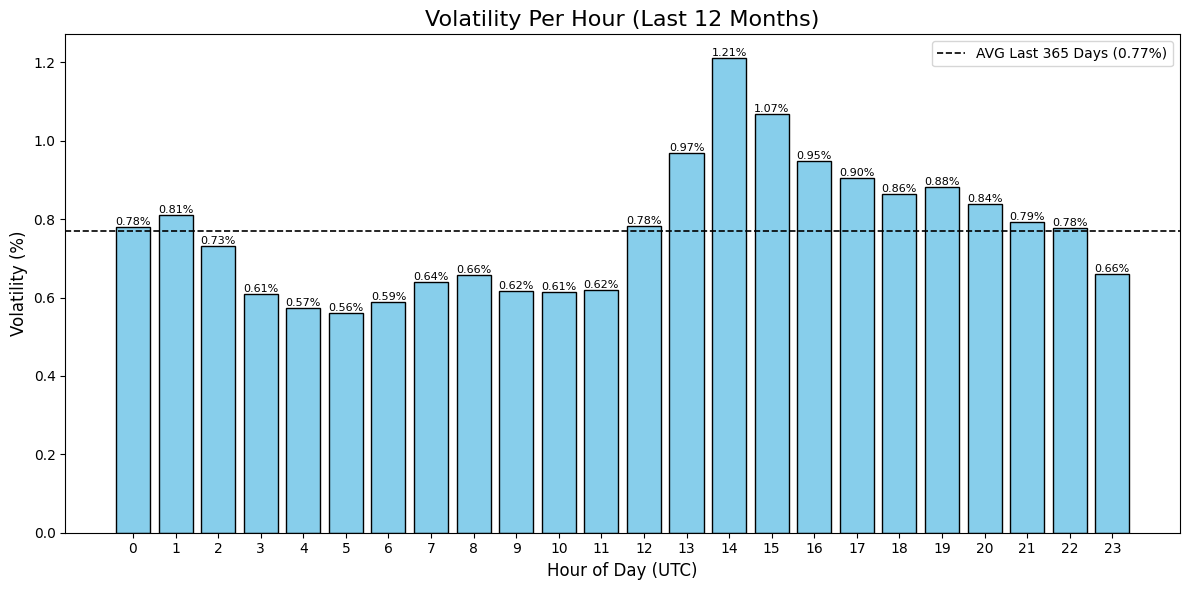

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
# Last 365 Days
# Example: Assuming your data is loaded into a DataFrame 'df'
# and contains 'datetime', 'high', and 'low' columns
# df = pd.read_csv('your_bitcoin_data.csv')  # Replace with your actual data file

# Convert datetime to a pandas datetime object
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])

# Filter data for the last 12 months (365 days)
last_12_months = datetime.now() - timedelta(days=365)
df_last_12_months = df_hourly[df_hourly['timestamp'] >= last_12_months]

# Extract hour from datetime
df_last_12_months['hour'] = df_last_12_months['timestamp'].dt.hour

# Calculate Hourly Volatility (High-Low Difference Percentage)
df_last_12_months['volatility'] = (df_last_12_months['high'] - df_last_12_months['low']) / df_last_12_months['low'] * 100

# Group by Hour and Calculate Average Volatility
hourly_volatility = df_last_12_months.groupby('hour')['volatility'].mean()

# Prepare the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(hourly_volatility.index, hourly_volatility, color='skyblue', edgecolor='black')

# Highlight the Average Line
average_hr_volatility_last_threehundredsixty = hourly_volatility.mean()
plt.axhline(y=average_hr_volatility_last_threehundredsixty, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 365 Days ({average_hr_volatility_last_threehundredsixty:.2f}%)')

# Annotate Bars with Values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

# Add Chart Labels and Title
plt.title('Volatility Per Hour (Last 12 Months)', fontsize=16)
plt.xlabel('Hour of Day (UTC)', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.legend()

# Show the Plot
plt.tight_layout()
plt.show()

In [35]:
average_hr_volatility_last_threehundredsixty

0.770765288014835

Summary:

In [36]:
print(average_hr_volatility_last_sevendays)
print(average_hr_volatility_last_thirtydays)
print(average_hr_volatility_last_ninetydays)
print(average_hr_volatility_last_onehundredeighty)
print(average_hr_volatility_last_threehundredsixty)

0.6558569197198737
0.80742375956675
0.7416390866060801
0.7703249408933658
0.770765288014835


/tmp/ipykernel_1116263/4068530531.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_3_months['hour'] = df_last_3_months['timestamp'].dt.hour
/tmp/ipykernel_1116263/4068530531.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_3_months['volatility'] = (df_last_3_months['high'] - df_last_3_months['low']) / df_last_3_months['low'] * 100


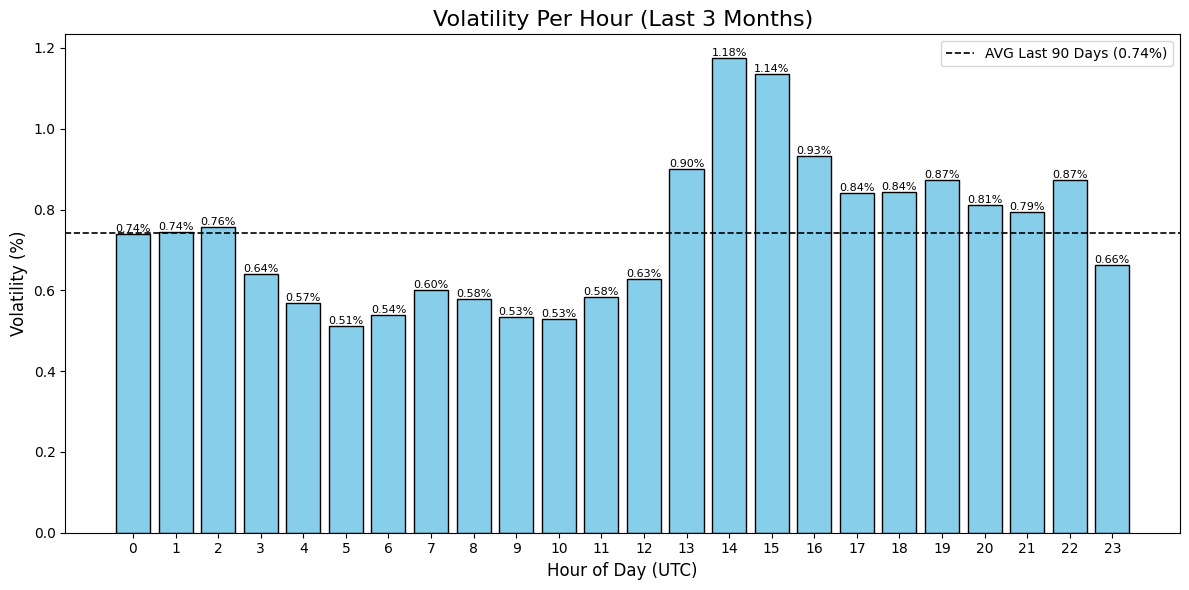

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
# Last 3 Month
# Example: Assuming your data is loaded into a DataFrame 'df'
# and contains 'datetime', 'high', and 'low' columns
# df = pd.read_csv('your_bitcoin_data.csv')  # Replace with your actual data file

# Convert datetime to a pandas datetime object
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])

# Filter data for the last 3 months (90 days)
last_3_months = datetime.now() - timedelta(days=90)
df_last_3_months = df_hourly[df_hourly['timestamp'] >= last_3_months]

# Extract hour from datetime
df_last_3_months['hour'] = df_last_3_months['timestamp'].dt.hour

# Calculate Hourly Volatility (High-Low Difference Percentage)
df_last_3_months['volatility'] = (df_last_3_months['high'] - df_last_3_months['low']) / df_last_3_months['low'] * 100

# Group by Hour and Calculate Average Volatility
hourly_volatility = df_last_3_months.groupby('hour')['volatility'].mean()

# Prepare the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(hourly_volatility.index, hourly_volatility, color='skyblue', edgecolor='black')

# Highlight the Average Line
average_volatility_last_ninetydays = hourly_volatility.mean()
plt.axhline(y=average_volatility_last_ninetydays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 90 Days ({average_volatility_last_ninetydays:.2f}%)')

# Annotate Bars with Values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

# Add Chart Labels and Title
plt.title('Volatility Per Hour (Last 3 Months)', fontsize=16)
plt.xlabel('Hour of Day (UTC)', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.legend()

# Show the Plot
plt.tight_layout()
plt.show()

<a name="id"></a>
[**Back to HOME**](#100)

<a id="4"></a>
**Volatility Summary:**

**Monthly:**

In [38]:
print(avg_volatility_last_years)
print(avg_volatility_three_years)
print(avg_volatility_five_years)
print(avg_volatility_ten_years)

4.277930219118517
4.2155380115411525
5.043027067757377
5.043027067757377


/tmp/ipykernel_1116263/222268517.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_years['volatility'] = (df_last_years['high'] - df_last_years['low']) / df_last_years['low'] * 100
/tmp/ipykernel_1116263/222268517.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_years['month_name'] = df_last_years['timestamp'].dt.month_name()


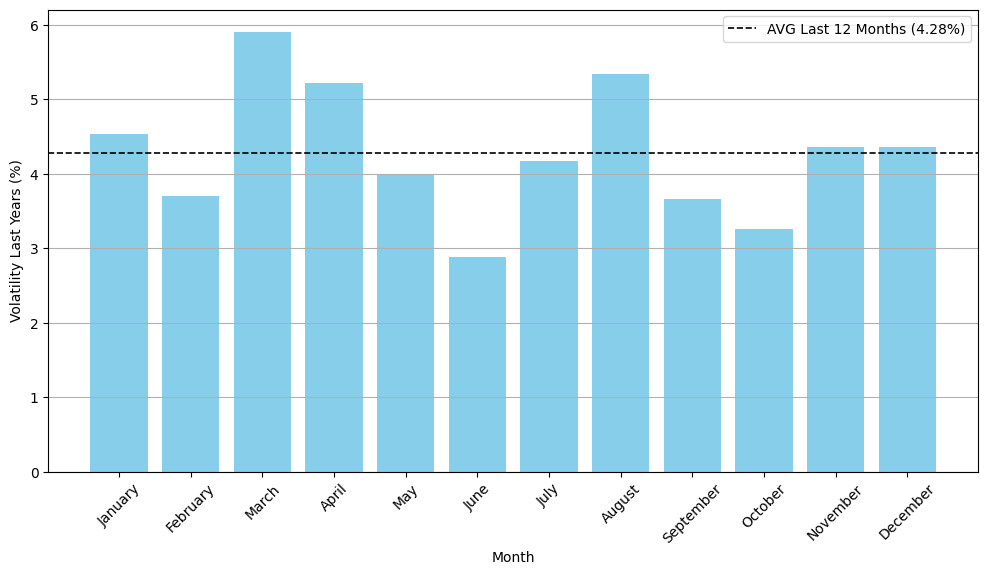

In [39]:
from datetime import timedelta
# Volatility last 12 Months
# Step 1: Filter the last 12 months
twelve_months_ago = df_daily['timestamp'].max() - timedelta(days=365)
df_last_years = df_daily[df_daily['timestamp'] >= twelve_months_ago]

# Step 2: Calculate Hourly Volatility (High-Low Difference Percentage)
df_last_years['volatility'] = (df_last_years['high'] - df_last_years['low']) / df_last_years['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_last_years['month_name'] = df_last_years['timestamp'].dt.month_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
monthly_volatility_last_years = df_last_years.groupby('month_name')['volatility'].mean()

# Sort by calendar order (January to December)
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_volatility_last_years = monthly_volatility_last_years.reindex(month_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(monthly_volatility_last_years.index, monthly_volatility_last_years, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_last_years = monthly_volatility_last_years.mean()
plt.axhline(y=avg_volatility_last_years, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 12 Months ({avg_volatility_last_years:.2f}%)')
plt.ylabel('Volatility Last Years (%)')
plt.xlabel('Month')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Daily:**

In [40]:
print(avg_volatility_last_sevendays)
print(avg_volatility_last_thirtydays)
print(avg_volatility_last_ninetydays)
print(avg_volatility_last_onehundredeightydays)
print(avg_volatility_last_threehundredsixtydays)

3.292174446845011
4.41697182567911
3.955606720038605
4.20933876407938
4.26533140763655


/tmp/ipykernel_1116263/425896180.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_ninetydays['volatility'] = (df_last_ninetydays['high'] - df_last_ninetydays['low']) / df_last_ninetydays['low'] * 100
/tmp/ipykernel_1116263/425896180.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_ninetydays['day_name'] = df_last_ninetydays['timestamp'].dt.day_name()


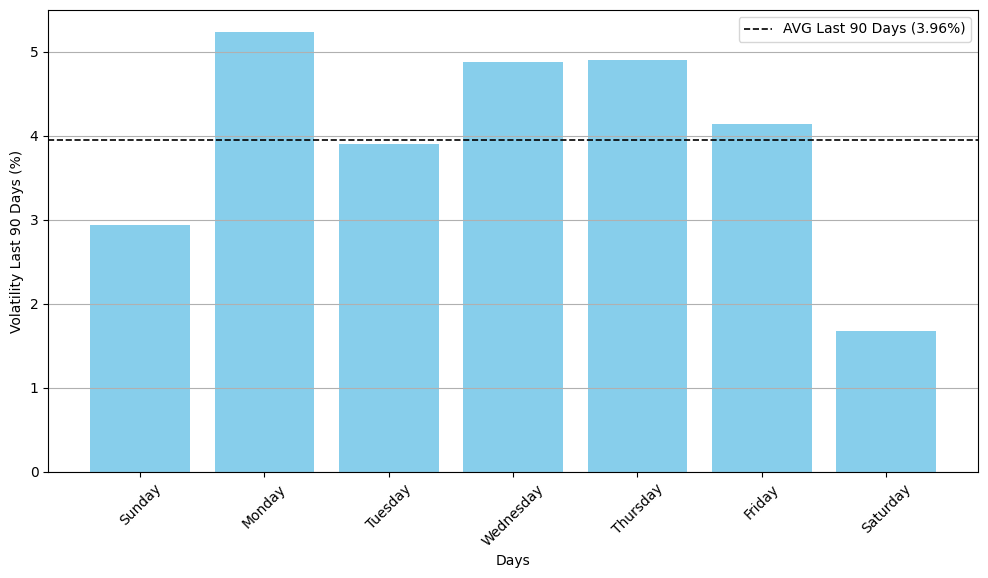

In [ ]:
from datetime import timedelta
# Volatility last 90 days
# Step 1: Filter the last 90 days
ninety_days_ago = df_daily['timestamp'].max() - timedelta(days=90)
df_last_ninetydays = df_daily[df_daily['timestamp'] >= ninety_days_ago]

# Step 2: Calculate Daily Volatility (High-Low Difference Percentage)
df_last_ninetydays['volatility'] = (df_last_ninetydays['high'] - df_last_ninetydays['low']) / df_last_ninetydays['low'] * 100


# Step 3: Add a 'month_name' column for grouping by month (January, February, etc.)
df_last_ninetydays['day_name'] = df_last_ninetydays['timestamp'].dt.day_name()

# Step 4: Group by 'month_name' and calculate the standard deviation of daily returns (volatility)
daily_volatility_last_ninetydays = df_last_ninetydays.groupby('day_name')['volatility'].mean()

# Sort by calendar order (January to December)
day_order = [
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
    'Saturday'
]
daily_volatility_last_ninetydays = daily_volatility_last_ninetydays.reindex(day_order)

# Step 5: Plot the monthly volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(daily_volatility_last_ninetydays.index, daily_volatility_last_ninetydays, color='skyblue')

# # Highlight the Average Line
# avg_volatility = monthly_volatility.mean()
# plt.axhline(y=monthly_volatility, color='black', linestyle='--', linewidth=1.2, label=f'AVG ({average_volatility:.2f}%)')plt.title('Monthly Volatility (Last 12 Months)')
# plt.axhline(y=avg_volatility_per_day.mean(), color='black', linestyle='--', label='Overall Average')

# Highlight the Average Line
avg_volatility_last_ninetydays = daily_volatility_last_ninetydays.mean()
plt.axhline(y=avg_volatility_last_ninetydays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 90 Days ({avg_volatility_last_ninetydays:.2f}%)')
plt.ylabel('Volatility Last 90 Days (%)')
plt.xlabel('Days')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Hourly:**

In [42]:
print(average_hr_volatility_last_sevendays)
print(average_hr_volatility_last_thirtydays)
print(average_hr_volatility_last_ninetydays)
print(average_hr_volatility_last_onehundredeighty)
print(average_hr_volatility_last_threehundredsixty)

0.6558569197198737
0.80742375956675
0.7416390866060801
0.7703249408933658
0.770765288014835


/tmp/ipykernel_1116263/4068530531.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_3_months['hour'] = df_last_3_months['timestamp'].dt.hour
/tmp/ipykernel_1116263/4068530531.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_3_months['volatility'] = (df_last_3_months['high'] - df_last_3_months['low']) / df_last_3_months['low'] * 100


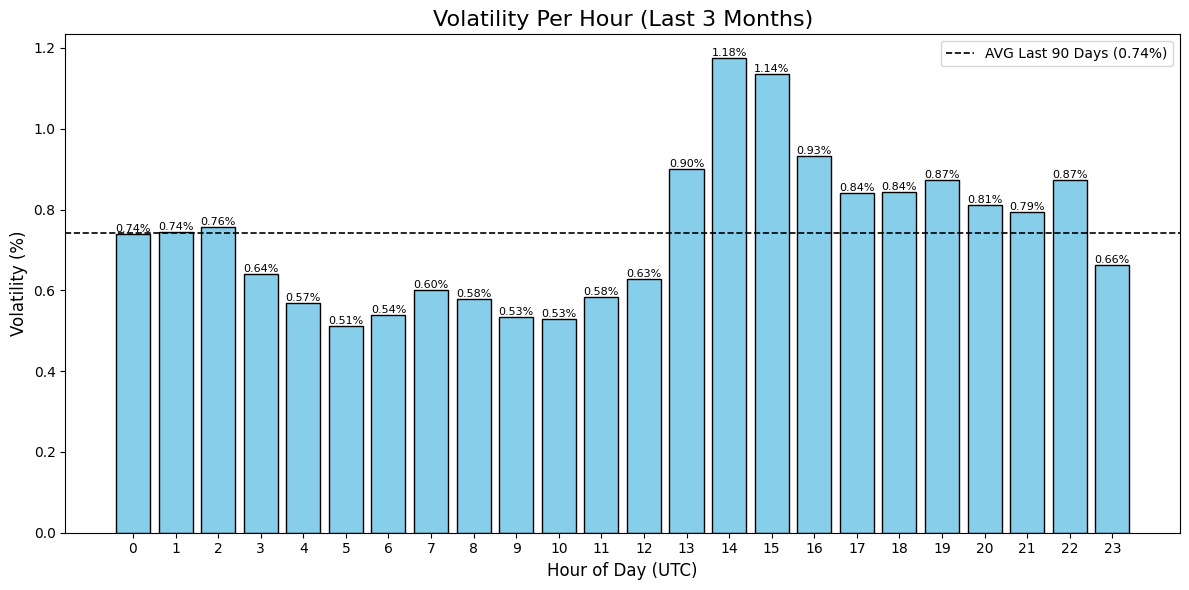

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
# Last 3 Month
# Example: Assuming your data is loaded into a DataFrame 'df'
# and contains 'datetime', 'high', and 'low' columns
# df = pd.read_csv('your_bitcoin_data.csv')  # Replace with your actual data file

# Convert datetime to a pandas datetime object
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])

# Filter data for the last 3 months (90 days)
last_3_months = datetime.now() - timedelta(days=90)
df_last_3_months = df_hourly[df_hourly['timestamp'] >= last_3_months]

# Extract hour from datetime
df_last_3_months['hour'] = df_last_3_months['timestamp'].dt.hour

# Calculate Hourly Volatility (High-Low Difference Percentage)
df_last_3_months['volatility'] = (df_last_3_months['high'] - df_last_3_months['low']) / df_last_3_months['low'] * 100

# Group by Hour and Calculate Average Volatility
hourly_volatility = df_last_3_months.groupby('hour')['volatility'].mean()

# Prepare the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(hourly_volatility.index, hourly_volatility, color='skyblue', edgecolor='black')

# Highlight the Average Line
average_volatility_last_ninetydays = hourly_volatility.mean()
plt.axhline(y=average_volatility_last_ninetydays, color='black', linestyle='--', linewidth=1.2, label=f'AVG Last 90 Days ({average_volatility_last_ninetydays:.2f}%)')

# Annotate Bars with Values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

# Add Chart Labels and Title
plt.title('Volatility Per Hour (Last 3 Months)', fontsize=16)
plt.xlabel('Hour of Day (UTC)', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.legend()

# Show the Plot
plt.tight_layout()
plt.show()

**Best Time to Trade BTCUSD Based on Volatility:**

* Monthly: Jan, March, April, August, Nov
* Daily: Monday, Tuesday, Wednesday, Thursday, Friday
* Hourly: 01-02, Increasing (10-14), Decreasing (14-20)

<a name="id"></a>
[**Back to HOME**](#100)